In [29]:
import numpy as np
import copy
from multiprocessing import Pool
import multiprocessing
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle 
%matplotlib inline

In [30]:
def init_pi(N_a,N_s):
    """
    function to generate policy,
    inputs:
        N_a - number of actions;
        N_s - number of states;
    outputs:
        pi(a|s) - np.array of shape N_a x N_s
    """
    np.random.seed(1453)
    Pi_matr = np.random.uniform(0.0,1.0,(N_a,N_s))
    norm_coef = Pi_matr.sum(axis=0)
    Pi_matr = Pi_matr / norm_coef.reshape((1,N_s))
    #check if stochastic
    #print(Pi_matr.sum(axis=0))
    return Pi_matr

In [31]:
def generate_dynamics(N_a,N_s,b):
    """
    function to generate transition probabilities,
    inputs:
        N_a - number of actions;
        N_s - number of states;
        b - branching number
    outputs:
        pi(s'|s,a) - np.array of shape N_s x N_s x N_a
    """
    np.random.seed(1812)
    inds_nonzero = np.zeros((N_s,N_a,b),dtype = int)
    for i in range(N_s):
        for j in range(N_a):
            inds_nonzero[i,j] = np.random.choice(N_s, size=b, replace=False)
    Pi_matr = np.zeros((N_s,N_s,N_a),dtype=float)
    for i in range(N_s):
        for j in range(N_a):
            Pi_matr[inds_nonzero[i,j],i,j] = np.random.uniform(0.0,1.0,b)
    norm_coef = Pi_matr.sum(axis=0)
    Pi_matr = Pi_matr / norm_coef.reshape((1,N_s,N_a))
    return Pi_matr,inds_nonzero

In [32]:
def state_transitions(P,pi):
    """
    function to generate transition probabilities,
    inputs:
        P(s'|s,a) - np.array of shape N_s x N_s x N_a, transition probabilities;
        pi(a|s) - np.array of shape N_a x N_s, policy;
    outputs:
        p(s'|s) - transition probability matrix of shape (N_s,N_s)
    """
    np.random.seed(1812)
    P_s = np.zeros((N_s,N_s),dtype = float)
    for i in range(N_s):
        for j in range(N_s):
            P_s[i,j] = np.dot(P[i,j,:],pi[:,j])
    return P_s 

In [33]:
def init_rewards(N_a,N_s):
    """
    function to generate rewards,
    inputs:
        N_a - number of actions;
        N_s - number of states;
    outputs:
        R(a,s) - np.array of rewards (shape N_a x N_s)  
    """
    np.random.seed(1821)
    R = Pi_matr = np.random.uniform(0.0,1.0,(N_a,N_s))
    return R

In [34]:
#global constants
#number of actions
N_a = 2
#number of states
N_s = 10
#gamma = 0.99
gamma = 0.9
#branching factor (external parameter for Garnet)
branch = 3

In [35]:
#init policy matrix
Policy = init_pi(N_a,N_s)
#init transition matrix
P,Inds_nz = generate_dynamics(N_a,N_s,branch)
#init rewards
R = init_rewards(N_a,N_s)
#init state transition matrix
S_trans = state_transitions(P,Policy)

### Solve system to find $\theta^*$ (i.e. true $V_{\pi}(s)$)

In [36]:
#system matrix
A = np.eye(N_s) - gamma*(S_trans.T)
#right hand side
b = np.sum(Policy*R,axis=0)
theta_star = np.linalg.inv(A) @ b
print(b)
print(theta_star)

[0.71889809 0.56176203 0.7028568  0.58086509 0.11065385 0.48332232
 0.34350863 0.70097716 0.55115417 0.51374463]
[5.27220987 5.22225305 5.43806472 5.27366874 4.83310775 5.03090872
 5.08173115 5.26029066 5.11108826 5.19779703]


### Find stationary distribution over state space

In [37]:
#note that in my notations they are usual (right) eigenvalues
eigvals, eigfuncs = np.linalg.eig(S_trans)
print(eigvals)
pi_states = -np.real(eigfuncs[:,0])
pi_states = pi_states/np.sum(pi_states)
#pi_states - statinary distribution over states
print(pi_states)
print(np.sum(pi_states))

[ 1.        +0.j          0.04375658+0.41636321j  0.04375658-0.41636321j
 -0.26498642+0.j         -0.16641571+0.19627497j -0.16641571-0.19627497j
  0.18278929+0.j          0.14418946+0.08057296j  0.14418946-0.08057296j
  0.0729122 +0.j        ]
[0.061358   0.12973764 0.12527139 0.14823597 0.09849189 0.04864512
 0.14811634 0.07481129 0.11326694 0.05206541]
1.0


In [38]:
#calculate covariance matrix Sigma_epsilon
Sigma_eps = np.zeros((N_s,N_s),dtype=float)
for s0 in range(N_s):
    for s in range(N_s):
        for a in range(N_a):
            eps = np.zeros(N_s,dtype=float)
            eps[s0] = R[a,s0] + gamma*theta_star[s]-theta_star[s0]
            eps_upd = eps.reshape((-1,1)) @ eps.reshape((1,-1))
            #averaging
            Sigma_eps += pi_states[s0]*Policy[a,s0]*P[s,s0,a]*eps_upd
#print estimated covariance matrix
print(Sigma_eps)

[[0.00161236 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00371063 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.02791094 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00269599 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00171354 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.00254726
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00806724 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.00331585 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00275466 0.        ]
 [0.         0.         0.   

### Find $\theta^*$ by another approach

In [39]:
A_star = np.zeros((N_s,N_s),dtype=float)
for i in range(N_s):
    for j in range(N_s):
        A_star[i,j] = pi_states[i]*S_trans[j,i]
A_star = np.diag(pi_states) - gamma*A_star
b_star = b*pi_states
theta_star_new = np.linalg.inv(A_star) @ b_star
print("error between different ways of calculating thetas star",np.linalg.norm(theta_star-theta_star_new))

error between different ways of calculating thetas star 1.130466570252318e-14


#### Check quality of normal approximation 

In [40]:
#Run TD(0) algorithm
N_iters = 2*10**6
v0 = 5*np.ones(N_s,dtype=float)
s0 = np.random.choice(N_s)
#step size
c0 = 4.0
alpha = np.zeros(N_iters,dtype=float)
for i in range(N_iters):
    alpha[i] = c0/np.sqrt(i+1)

In [41]:
#compute cumulative sums
Policy_cumulative = Policy.cumsum(axis=0)
print(Policy_cumulative)

[[0.66711619 0.3552804  0.26331904 0.6638734  0.37314812 0.42164785
  0.34472678 0.55015609 0.61498269 0.52219635]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]


In [42]:
Cumulative_state = np.zeros((branch,N_s,N_a))
for s in range(N_s):
    for a in range(N_a):
        cur_pol = P[Inds_nz[s,a],s,a]
        Cumulative_state[:,s,a] = cur_pol.cumsum()
print(Cumulative_state.shape)

(3, 10, 2)


In [15]:
def check_independent_parallel(seed,alpha,s_0,N_traj,N_iters,n_b = N_iters // 2):
    V_funcs = np.zeros((N_traj,N_iters,N_s))
    np.random.seed(seed)
    #burn-in 
    n0 = n_b
    PR_V = np.zeros((N_traj,N_iters-n0,N_s))
    ###Main loop
    V = 5*np.ones((N_traj,N_s),dtype=float)
    for N in range(N_iters):
        #generate a set of indices
        s0 = np.random.choice(N_s, N_traj, replace=True, p = pi_states)
        #sample action
        #compute policy vectors
        Prob_vectors = Policy_cumulative[:,s0]
        a = (Prob_vectors < np.random.rand(1, N_traj)).argmin(axis=0)
        #sample next state
        #join state and actio pair 
        Pr_v = Cumulative_state[:,s0,a]
        s_inds = (Pr_v < np.random.rand(1, N_traj)).argmin(axis=0)
        s = Inds_nz[s0,a,s_inds]
        #calculate J0
        eps = np.zeros((N_traj,N_s),dtype=float)
        eps[np.arange(N_traj),s0] = R[a,s0] + gamma*V[np.arange(N_traj),s]-V[np.arange(N_traj),s0]
        #TD update
        V += alpha[N]*eps
        #save value function
        V_funcs[:,N,:] = V
        #update PR
        if N == n0:
            PR_V[:,0,:] = V
        elif N > n0:
            PR_V[:,N-n0,:] = (PR_V[:,N-n0-1,:]*(N-n0) + V) / (N-n0+1)
    return V_funcs,PR_V

In [16]:
def check_independent_last(seed,alpha,s_0,N_traj,n_iters):
    N_max = 12800
    V_funcs = np.zeros((N_max,N_s),dtype=float)
    np.random.seed(seed)
    #burn-in 
    n0 = n_iters // 2
    PR_V = np.zeros((N_traj,N_s),dtype=float)
    ###Main loop
    n_loops = N_traj // N_max
    for i in range(n_loops):
        V = 5*np.ones((N_max,N_s),dtype=float)
        for N in range(n_iters):
            #generate a set of indices
            s0 = np.random.choice(N_s,  N_max, replace=True, p = pi_states)
            #sample action
            #compute policy vectors
            Prob_vectors = Policy_cumulative[:,s0]
            a = (Prob_vectors < np.random.rand(1,  N_max)).argmin(axis=0)
            #sample next state
            #join state and actio pair 
            Pr_v = Cumulative_state[:,s0,a]
            s_inds = (Pr_v < np.random.rand(1,  N_max)).argmin(axis=0)
            s = Inds_nz[s0,a,s_inds]
            #calculate J0
            eps = np.zeros(( N_max,N_s),dtype=float)
            eps[np.arange( N_max),s0] = R[a,s0] + gamma*V[np.arange(N_max),s]-V[np.arange(N_max),s0]
            #TD update
            V += alpha[N]*eps
            #update PR
            if N == n0:
                PR_V[i*N_max:(i+1)*N_max,:] = V
            elif N > n0:
                PR_V[i*N_max:(i+1)*N_max,:] = (PR_V[i*N_max:(i+1)*N_max,:]*(N-n0) + V) / (N-n0+1)
    return PR_V

In [17]:
seed = 2024
N_traj = 409600
res_last = []
res_pr = []
#number of iterations
N_iters = [200,400,800,1600,3200,6400,12800,25600,51200,102400,204800,409600,819200]
N_iters = np.asarray(N_iters)
for i in range(len(N_iters)):
    pr_iter = check_independent_last(seed + i,alpha,s0,N_traj,N_iters[i])
    #append strange arrays here
    #res_last.append(last_iter)
    res_pr.append(pr_iter)

In [18]:
print(res_pr[0])

[[5.35095684 5.31098001 5.26963476 ... 5.29238304 5.17402496 5.27997056]
 [5.19737096 5.13893591 5.24939986 ... 5.32924575 4.9986507  4.94016748]
 [4.96069191 5.06388254 5.26927188 ... 4.95329    4.9784447  4.9336733 ]
 ...
 [4.94146418 4.89930733 4.88941784 ... 4.90143624 4.68555625 4.84933984]
 [5.67830664 5.4329267  5.4987585  ... 5.48866855 5.57195701 5.47574379]
 [5.35626076 5.36010826 5.42765784 ... 5.39374792 5.31485062 5.33995325]]


In [19]:
#Compute error norms
#error_norm = np.linalg.norm(res_last[0] - theta_star.reshape((1,1,-1)),axis=2)
#same for PR
#error_norm_PR = np.linalg.norm(res_pr[0] - theta_star.reshape((1,1,-1)),axis=2)

### Plot error norm

In [20]:
#plot last iterate
plt.figure(figsize=(12,8)) 
plt.plot(np.arange(N_0,N_iters), error_norm.mean(axis=0)[N_0:], linestyle='--', marker='o', color='r', label='Last iterate error') 
plt.plot(np.arange(N_0,N_iters), error_norm_PR.mean(axis=0), linestyle='--', marker='o', color='b', label='PR error')
plt.xlabel('iteration number',fontsize = 18)
#plt.yscale('log')
plt.legend() 
plt.show()

NameError: name 'N_0' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
#plot last iterate
plt.figure(figsize=(12,8)) 
plt.plot(np.arange(N_0,N_iters), error_norm.mean(axis=0)[N_0:]/np.sqrt(alpha[N_0:]), linestyle='--', marker='o', color='r', label='Last iterate error') 
plt.plot(np.arange(N_0,N_iters), error_norm_PR.mean(axis=0)*np.sqrt(1+np.arange(N_iters-N_0)), linestyle='--', marker='o', color='b', label='PR error')
plt.xlabel('iteration number',fontsize = 18)
plt.yscale('log')
plt.legend() 
plt.show()

### Compute PR statistics, check quality of normal approximation

In [21]:
np.random.seed(2024)
#generate random direction
U = np.random.randn(N_s)
u = U/np.linalg.norm(U)
#compute the emirical CDF 
pr_samples = []

for i in range(len(N_iters)):
    print(res_pr[i].shape)
    norm_samples = np.sqrt(N_iters[i]//2)*A_star @ (res_pr[i] - theta_star.reshape((1,-1))).transpose()
    pr_samples.append(norm_samples)

(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)
(409600, 10)


In [22]:
sample = []
for i in range(len(N_iters)):
    err_proj = pr_samples[i].transpose() @ u
    sample.append(err_proj)
sample = np.asarray(sample)
print(sample.shape)

(13, 409600)


In [23]:
sample_pickl = {'description':"Experiments 05.04.2024, step size k^{-1/2}, 409600 trajectories",'samle size':N_iters,'sample':sample}
with open('res_04_04.pickle', 'wb') as handle:
    pickle.dump(sample_pickl, handle)

In [44]:
with open('res_07_04.pickle', 'rb') as handle:
    sample_pickl = pickle.load(handle)

In [45]:
sample = sample_pickl['sample']

In [60]:
N_iters = np.asarray([200,400,800,1600,3200,6400,12800,25600,51200,102400,204800,409600,819200],dtype=float)
N_traj = 819200

all_ks = []
loc = 0.0
scale = (Sigma_eps @ u).dot(u)
for i in range(len(N_iters)):
    sample_sort = np.sort(sample[i])
    ecdf = np.linspace(0,1,N_traj+1)
    cdfs = norm.cdf(sample_sort, loc = 0, scale = np.sqrt(scale))
    ks_dist = max([(ecdf[1:] - cdfs).max(), (cdfs - ecdf[:-1]).max()])
    all_ks.append(ks_dist)

In [61]:
print(all_ks)

[0.0456739745438737, 0.026094991739075868, 0.0191850703640975, 0.013723261016368976, 0.009140662356740104, 0.006963304047993252, 0.004288317105556438, 0.003524214011990656, 0.002370933801688374, 0.0018991756853847797, 0.0020394972762264874, 0.0010935965404907932, 0.0012482989419618506]


In [62]:
print(N_iters)

[2.000e+02 4.000e+02 8.000e+02 1.600e+03 3.200e+03 6.400e+03 1.280e+04
 2.560e+04 5.120e+04 1.024e+05 2.048e+05 4.096e+05 8.192e+05]


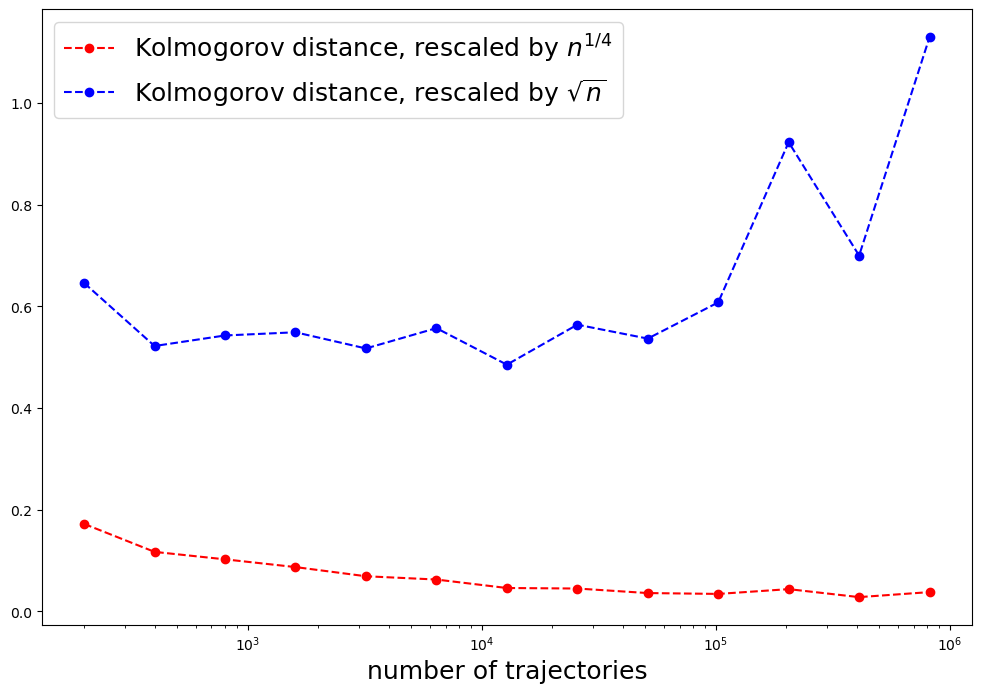

In [63]:
#plot last iterate
plt.figure(figsize=(12,8)) 
plt.plot(N_iters, (N_iters**0.25)*all_ks, linestyle='--', marker='o', color='r', label='Kolmogorov distance, rescaled by $n^{1/4}$') 
plt.plot(N_iters, (N_iters**0.5)*all_ks, linestyle='--', marker='o', color='b', label='Kolmogorov distance, rescaled by $\sqrt{n}$') 
plt.xlabel('number of trajectories',fontsize = 18)
plt.xscale('log')
#plt.yscale('log')
plt.legend(fontsize=18)
plt.savefig("test_kolmogorov_dist_07_04.pdf")
plt.show()